## Load Spotify API

In [1]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [2]:
with open('./config.json') as f:
    config = json.load(f)
client_id = config['client_id']
client_secret = config['client_secret']
redirect_uri='https://www.google.com/'

In [3]:
username = config['username']
client_creds_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
scope = "user-library-read playlist-read-private"
try:
    token = util.prompt_for_user_token(username, scope, client_id=client_id, 
                                       client_secret=client_secret, redirect_uri=redirect_uri)
    sp = spotipy.Spotify(auth=token)
except:
    print(f'token is not accessible for {username}')

## Grab Data from Spotify API

In [4]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
playlist_dict = {
    "Get Turnt": "37i9dQZF1DWY4xHQp97fN6",
    "Classical Essentials": "37i9dQZF1DWWEJlAGA9gs0", #37i9dQZF1DXaXB8fQg7xif
    "Rock Save the Queen" : "37i9dQZF1DXcDnIr0iKAG8",
    "Coffee Table Jazz" : "37i9dQZF1DWVqfgj8NZEp1"
}
spotify_username = 'Spotify'

In [6]:
# Load the playlists into objects
playlists = [sp.user_playlist(spotify_username, playlist_id=v) for _, v in playlist_dict.items()]

In [7]:
def extract_playlist_info(playlists):
    df_playlists = []
    for playlist in playlists:
        playlist_items = playlist['tracks']['items']
        df_playlist = pd.DataFrame(columns=('song_id', 'song_name', 'song_artist'))
        for item in playlist_items:
            track = item['track']
            df_playlist = df_playlist.append(
                {
                    'song_id': track['id'],
                    'song_name': track['name'],
                    'song_artist': track['artists'][0]['name']
                },
                ignore_index=True
            )
        df_playlists.append(df_playlist)
    return df_playlists

In [8]:
def extract_audio_features(df_playlists):
    df_features_list = []
    columns = ['song_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 
            'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
    for df_playlist in df_playlists:
        song_ids = list(df_playlist['song_id'])
        df_audio_features = pd.DataFrame(data=sp.audio_features(tracks=song_ids))
        
        df_features = df_audio_features[columns[1:]].join(df_playlist['song_name'])
        df_features_list.append(df_features[columns]) # put columns inside to make sure song_name 
                                                      #is the first column.
    return df_features_list

In [9]:
df_playlists = extract_playlist_info(playlists)
df_features_list = extract_audio_features(df_playlists)
pprint(df_features_list[0].loc[4])
print()
pprint(df_features_list[2].loc[8])

song_name           Pure Water (with Migos)
danceability                           0.68
energy                                0.559
key                                       0
loudness                             -5.545
mode                                      1
speechiness                           0.129
acousticness                          0.172
instrumentalness                          0
valence                               0.137
tempo                               202.006
Name: 4, dtype: object

song_name                One
danceability           0.487
energy                 0.839
key                        2
loudness              -5.875
mode                       1
speechiness           0.0417
acousticness        0.000134
instrumentalness      0.0891
valence                0.504
tempo                157.984
Name: 8, dtype: object


## Setting up Training Data

In [10]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
def convert_df_to_array(df):
    converted_list = []
    for _, row in df.iterrows():
        converted_list.append(np.array(list(row[1:])))  # use 1: to avoid adding in song name
    return np.asarray(converted_list)

In [12]:
def create_X_data(df_features_list):
    X = []
    for df_features in df_features_list:
        converted_array = convert_df_to_array(df_features)
        for item in converted_array:
            X.append(item)
    return np.asarray(X)

In [13]:
def create_y_data():
    y = np.array([])
    for i in range(0, 4):
        y = np.append(y, np.ones(shape=(100, 1)) * i)
    return y

In [14]:
X = create_X_data(df_features_list) 
X.shape

(400, 10)

In [15]:
y = to_categorical(create_y_data())
y.shape

(400, 4)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # data set small
                                                                                          # so smaller test size
X_train.shape, y_train.shape

((360, 10), (360, 4))

## Create Model

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Model V1

In [19]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [20]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=90, epochs=30)

Epoch 1/30
360/360 [==============================] - 0s 943us/step - loss: 10.4069 - acc: 0.2444
Epoch 2/30
360/360 [==============================] - 0s 43us/step - loss: 9.9881 - acc: 0.2583
Epoch 3/30
360/360 [==============================] - 0s 40us/step - loss: 10.4282 - acc: 0.2361
Epoch 4/30
360/360 [==============================] - 0s 44us/step - loss: 9.3112 - acc: 0.2667
Epoch 5/30
360/360 [==============================] - 0s 39us/step - loss: 7.1670 - acc: 0.2278
Epoch 6/30
360/360 [==============================] - 0s 38us/step - loss: 4.1090 - acc: 0.2833
Epoch 7/30
360/360 [==============================] - 0s 54us/step - loss: 1.4934 - acc: 0.3111
Epoch 8/30
360/360 [==============================] - 0s 45us/step - loss: 1.4380 - acc: 0.2778
Epoch 9/30
360/360 [==============================] - 0s 32us/step - loss: 1.3285 - acc: 0.2694
Epoch 10/30
360/360 [==============================] - 0s 35us/step - loss: 1.3965 - acc: 0.2972
Epoch 11/30
360/360 [===============

In [21]:
model.evaluate(X_test, y_test, batch_size=90)

40/40 [==============================] - 0s 673us/step


[1.2701127529144287, 0.55000001192092896]

In [22]:
y_pred = model.predict(X_test)
y_pred

array([[ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.24888861,  0.25400254,  0.24612528,  0.25098351],
       [ 0.25208896,  0.2406031 ,  0.25427231,  0.2530356 ],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.0203288 ,  0.79694366,  0.01474177,  0.16798574],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25072426,  0.24668626,  0.24928151,  0.25330803],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.2404132 ,  0.28901204,  0.23239675,  0.23817803],
       [ 0.25233054,  0.24031872,  0.25460261,  0.25274819],
       [ 0.25233054,  0.

Confusion matrix, without normalization
[[ 0  0 12  0]
 [ 0  9  0  0]
 [ 0  0 11  0]
 [ 0  6  0  2]]


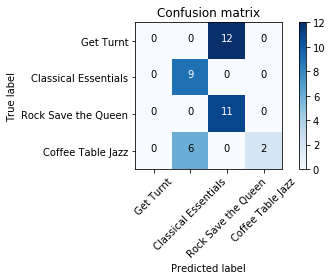

In [23]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Looking at this confusion matrix, I notice 3 things.
1. Testing dataset is very small. I need to expand my total data set
2. Coffee table jazz and Get Turnt are not being classfied correctly. Exploration is needed to see why
3. Rock save the queen is doing quite well. Exploration is needed to see why.

### Model V2

In [24]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=10))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

In [25]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train, batch_size=60, epochs=150)
model.evaluate(X_test, y_test, batch_size=60)

Epoch 1/150
300/300 [==============================] - 1s 4ms/step - loss: 8.8973 - acc: 0.2633
Epoch 2/150
300/300 [==============================] - 0s 51us/step - loss: 8.4878 - acc: 0.2967
Epoch 3/150
300/300 [==============================] - 0s 87us/step - loss: 5.9554 - acc: 0.2500
Epoch 4/150
300/300 [==============================] - 0s 57us/step - loss: 2.8225 - acc: 0.3133
Epoch 5/150
300/300 [==============================] - 0s 82us/step - loss: 1.5164 - acc: 0.2833
Epoch 6/150
300/300 [==============================] - 0s 51us/step - loss: 1.4361 - acc: 0.3467
Epoch 7/150
300/300 [==============================] - 0s 180us/step - loss: 1.3120 - acc: 0.3767
Epoch 8/150
300/300 [==============================] - 0s 68us/step - loss: 1.3167 - acc: 0.3900
Epoch 9/150
300/300 [==============================] - 0s 69us/step - loss: 1.2500 - acc: 0.3833
Epoch 10/150
300/300 [==============================] - 0s 54us/step - loss: 1.2258 - acc: 0.4067
Epoch 11/150
300/300 [=======

[0.79672960042953489, 0.57000001668930056]

Confusion matrix, without normalization
[[ 9  0 15  7]
 [ 0 13  0  8]
 [ 7  0 18  0]
 [ 0  6  0 17]]


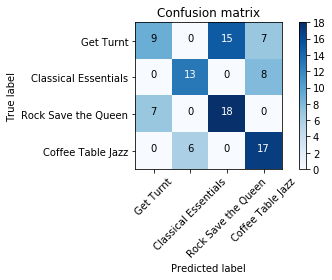

In [27]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Changing the amount of neurons in the first layer, drop out rate, batch size and epochs makes quite a big difference. The new model has a more consistent accuracy, a significant improvement from the first version. 
I feel that data exploration is still needed. Maybe I need to change my dataset and eliminate some redundant columns.
Data Exploration will help me indicate what I columns would be most unique.

## Exploration

In [41]:
def get_feature(column, operation):
    categories = ['Get Turnt', 'Classical Essentials', 'Rock Save The Queen', 'Coffee Table Jazz']
    idx = 0
    for df_feature in df_features_list:
        if operation == 'mean':
            result = df_feature[column].mean()
        elif operation == 'std':
            result = df_feature[column].std()
        elif operation == 'var':
            result = df_feature[column].var()
        print(f'{operation} for {categories[idx]} is: {result}')
        idx += 1

In [53]:
def get_features(columns, operation):
    for column in columns:
        print(f'Feature: {column}')
        get_feature(column, operation)
        print()

In [54]:
columns = df_features_list[0].columns[1:]
get_features(columns, 'mean')

Feature: danceability
mean for Get Turnt is: 0.8199299999999999
mean for Classical Essentials is: 0.259256
mean for Rock Save The Queen is: 0.46564999999999995
mean for Coffee Table Jazz is: 0.4407500000000001

Feature: energy
mean for Get Turnt is: 0.6375
mean for Classical Essentials is: 0.11576170000000001
mean for Rock Save The Queen is: 0.8428500000000001
mean for Coffee Table Jazz is: 0.13658599999999999

Feature: key
mean for Get Turnt is: 5.09
mean for Classical Essentials is: 5.39
mean for Rock Save The Queen is: 5.01
mean for Coffee Table Jazz is: 5.1

Feature: loudness
mean for Get Turnt is: -6.157150000000001
mean for Classical Essentials is: -23.28731
mean for Rock Save The Queen is: -4.633870000000001
mean for Coffee Table Jazz is: -18.281470000000002

Feature: mode
mean for Get Turnt is: 0.54
mean for Classical Essentials is: 0.66
mean for Rock Save The Queen is: 0.63
mean for Coffee Table Jazz is: 0.63

Feature: speechiness
mean for Get Turnt is: 0.20607899999999998
mea

In [55]:
columns = ['key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
get_features(columns, 'std')

Feature: key
std for Get Turnt is: 3.7446122912954833
std for Classical Essentials is: 3.22520064366842
std for Rock Save The Queen is: 4.013852276929247
std for Coffee Table Jazz is: 3.445096060879416

Feature: loudness
std for Get Turnt is: 1.845915514963737
std for Classical Essentials is: 6.75518373897955
std for Rock Save The Queen is: 1.2968479631379115
std for Coffee Table Jazz is: 4.646458117695127

Feature: mode
std for Get Turnt is: 0.5009082659620331
std for Classical Essentials is: 0.47609522856952335
std for Rock Save The Queen is: 0.4852365870939097
std for Coffee Table Jazz is: 0.4852365870939097

Feature: speechiness
std for Get Turnt is: 0.11962027656148629
std for Classical Essentials is: 0.009136107685243408
std for Rock Save The Queen is: 0.04170642970559671
std for Coffee Table Jazz is: 0.008175909179356807

Feature: acousticness
std for Get Turnt is: 0.09083253277234091
std for Classical Essentials is: 0.0910103779186137
std for Rock Save The Queen is: 0.038637896

Looking at the means and Std Dev of the features, I can see that features with similar/close means may are not 'unique' features for the model. Furthermore, the features with similar means to one another and relatively close Std devs would be features that I may not want to use anymore. Features such as: tempo, key and mode. Speechiness and loudness are features that I could remove but I feel that the variation in values from category to category for these features may be more beneficial for the model.

## Model Revision 

### Change Training and Testing Data

In [71]:
new_data_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence']

In [87]:
def rev_convert_df_to_array(df):
    converted_list = []
    for _, row in df.iterrows():
        converted_list.append(np.array(list(row)))
    return np.asarray(converted_list)

In [88]:
def rev_create_X_data(df_features_list):
    X = []
    for df_features in df_features_list:
        converted_array = rev_convert_df_to_array(df_features[new_data_columns])
        for item in converted_array:
            X.append(item)
    return np.asarray(X)

In [89]:
def rev_create_y_data():
    y = np.array([])
    for i in range(0, 4):
        y = np.append(y, np.ones(shape=(100, 1)) * i)
    return y

In [91]:
X = rev_create_X_data(df_features_list) 
X.shape

(400, 7)

In [92]:
y = to_categorical(rev_create_y_data())
y.shape

(400, 4)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((300, 7), (300, 4))

### Model V3

In [115]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=7))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

In [116]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model.fit(X_train, y_train, batch_size=60, epochs=150, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, batch_size=60)

Train on 360 samples, validate on 40 samples
Epoch 1/150
360/360 [==============================] - 0s 58us/step - loss: 0.6237 - acc: 0.6889 - val_loss: 0.5244 - val_acc: 0.8250
Epoch 2/150
360/360 [==============================] - 0s 45us/step - loss: 0.6083 - acc: 0.6556 - val_loss: 0.5274 - val_acc: 0.8000
Epoch 3/150
360/360 [==============================] - 0s 54us/step - loss: 0.6400 - acc: 0.6528 - val_loss: 0.5292 - val_acc: 0.7750
Epoch 4/150
360/360 [==============================] - 0s 54us/step - loss: 0.6368 - acc: 0.6528 - val_loss: 0.5230 - val_acc: 0.8250
Epoch 5/150
360/360 [==============================] - 0s 50us/step - loss: 0.6160 - acc: 0.6861 - val_loss: 0.5225 - val_acc: 0.8250
Epoch 6/150
360/360 [==============================] - 0s 46us/step - loss: 0.6281 - acc: 0.6833 - val_loss: 0.5230 - val_acc: 0.8250
Epoch 7/150
360/360 [==============================] - 0s 43us/step - loss: 0.6405 - acc: 0.6583 - val_loss: 0.5221 - val_acc: 0.8250
Epoch 8/150
360/3

360/360 [==============================] - 0s 69us/step - loss: 0.5841 - acc: 0.6889 - val_loss: 0.4988 - val_acc: 0.7250
Epoch 62/150
360/360 [==============================] - 0s 49us/step - loss: 0.5810 - acc: 0.6917 - val_loss: 0.4893 - val_acc: 0.8250
Epoch 63/150
360/360 [==============================] - 0s 97us/step - loss: 0.5621 - acc: 0.7417 - val_loss: 0.4908 - val_acc: 0.8000
Epoch 64/150
360/360 [==============================] - 0s 73us/step - loss: 0.5611 - acc: 0.7278 - val_loss: 0.4934 - val_acc: 0.7250
Epoch 65/150
360/360 [==============================] - 0s 49us/step - loss: 0.5637 - acc: 0.7000 - val_loss: 0.4846 - val_acc: 0.8250
Epoch 66/150
360/360 [==============================] - 0s 65us/step - loss: 0.5625 - acc: 0.7250 - val_loss: 0.4861 - val_acc: 0.7750
Epoch 67/150
360/360 [==============================] - 0s 98us/step - loss: 0.5631 - acc: 0.7028 - val_loss: 0.4786 - val_acc: 0.8500
Epoch 68/150
360/360 [==============================] - 0s 71us/step

360/360 [==============================] - 0s 69us/step - loss: 0.5533 - acc: 0.7361 - val_loss: 0.4506 - val_acc: 0.8250
Epoch 122/150
360/360 [==============================] - 0s 82us/step - loss: 0.5445 - acc: 0.7361 - val_loss: 0.4615 - val_acc: 0.8000
Epoch 123/150
360/360 [==============================] - 0s 70us/step - loss: 0.5119 - acc: 0.7528 - val_loss: 0.4511 - val_acc: 0.8250
Epoch 124/150
360/360 [==============================] - 0s 59us/step - loss: 0.5321 - acc: 0.7250 - val_loss: 0.4567 - val_acc: 0.7750
Epoch 125/150
360/360 [==============================] - 0s 60us/step - loss: 0.5319 - acc: 0.7056 - val_loss: 0.4514 - val_acc: 0.8250
Epoch 126/150
360/360 [==============================] - 0s 57us/step - loss: 0.5544 - acc: 0.7361 - val_loss: 0.4607 - val_acc: 0.8250
Epoch 127/150
360/360 [==============================] - 0s 91us/step - loss: 0.5422 - acc: 0.7111 - val_loss: 0.4514 - val_acc: 0.7750
Epoch 128/150
360/360 [==============================] - 0s 68

[0.44227123260498047, 0.77499997615814209]

Confusion matrix, without normalization
[[9 0 3 0]
 [0 7 0 2]
 [2 0 9 0]
 [0 1 0 7]]


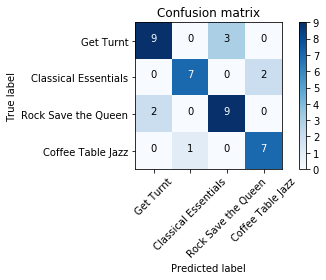

In [111]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()